# AutoML for hyperparameter optimization on VAEs for fast simulation

This notebook implements an automated machine learning for hyperparameter optimization with the library keras_tuner. 

The algorithm used to optimize is the random search, which randomly picks a set of hyperparameters, trains a model with them, and calculates a score. This score is used to compare between models to see which one is best.

The machine learning model is a variational autoencoder.

The goal is to train the model to be a shower simultor. The data the algorithm is being trained on is 10k events from a Pb detector geometry segemented in (r,phi,z) with particles of 60 GeV energy and an incident angle perdendicular to the detector.

## Import libraries used

The libraries used, and the versions used when testing this notebook are:

Python 3.8.8

tensorflow=2.5.0 | 
with keras=2.5.0 | 
keras_tuner=1.0.3 | 
numpy=1.19.5 | 
matplotlib=3.3.4 | 
h5py=3.1.0 | 
scikit-image=0.18.1 | 
sklearn=0.24.1

In [1]:
# To build and train the machine learning model
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras import metrics, optimizers
from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Multiply, Add, concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping

# To build the automl and optimize the hyperparameters for the model
import keras_tuner
from keras_tuner import RandomSearch

# To make math
import numpy as np
# To plot the results 
import matplotlib.pyplot as plt
# To import the data into the notebook
import h5py

#To partition the data in train, test and validation splits.
from sklearn.model_selection import train_test_split

#To calculate some metrics for computing the model score and for 
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

# To get trials data from the computer, implement a regex and analyse the trials
import os
import re
# To not show warnings from tensorflow
import logging
tf.get_logger().setLevel(logging.ERROR)

## Reading and Normalizing the data

Cell energies are the values of the energies for each cell of the 24x24x24 detector after the incident particle collides, in each one of the events.

Particle energies are the energies of the incident particle for each event. In the case of this example, these are all the same value, 60 GeV.

In [2]:
# Import the data from the hdf5 file
fName ='./data.hdf5' 
h5File = h5py.File(fName,'r')
cell_energies = np.array(h5File['events_cells'])
particle_energies = np.array(h5File['events_particles'])
h5File.close()


# Normalize the data, scaling it to [0,1]
maxE = np.max(cell_energies)
cell_energies /= maxE

# Reshape the dataset to have the same shape as input for the mode
nbCells = 24
input_dim = nbCells*nbCells*nbCells
cell_energies = cell_energies.reshape( len(cell_energies) , input_dim )

# Divide the data into train (8000 events), test (1000 events) and validation (1000 events) sets
train_data, test_data = train_test_split(cell_energies, test_size=int(len(cell_energies)*0.1), random_state=42)
train_data, val_data = train_test_split(train_data, test_size=1000, random_state=42)

# Generates the noise
noise = np.random.normal(0,1, size = (8000,10))
noise2 = np.random.normal(0,1, size = (1000,10))

## Implement the Variational Autoencoder model

### Initializers

Here, we define a class to be the VAE model. 

It is composed with the __init__ function, which sets the choices for the hyperparameters (hp) we want to optimize, some other variables needed for the model, and also all the layers we are going to use to build the encoder and the decoder.

The hyperparameters to be optimized define here are:

Learning rate | Activation function for the intermediate layers | Weight for the kl divergence loss | Opmization function | Kernel initializer | Bias initilizer | Number of layers | Number of units for each layer.

### VAE model (encoder and decoder)

Also, there are one function for the encoder and one for the decoder. They have as input the input tensors (in case of the encoder, one for the energies, and one for the noise). Then, they associate the layers defined before into a model, and return the output layer.

For the __encoder__, it starts with the input layer, then the dense layers + batch normalization after each (the amount of the dense layers is also a hp to be optimized). After it, there are two layers, which defines the gaussian distribution we generate with the encoder, one representing the mean, and one representing the variance. Having the values for the distribution, we sample a value from it to describe the input we got. This is done by multiplying the variance layer by a random noise and summing this to the mean layer. 

For the __decoder__, it also starts with the input layer (which should be a latent vector picked randomly from a gaussian distribution or the output of the encoder), then we have the dense layers + batch normalization for each (the same amount as the encoder) and, at the end, a final dense layer to generate the output.

Now, we need to combine the encoder and the decoder into something the model is going to use to train the VAE, and that is the __call__ function. It receives the input, which is the x, for the encoder (the train_data and noise) and also the y, which is used to compare the result with. Since this is an autoencoder, we want to train the model to reproduce the input, so y is also the train_data. Well, the x goes into the encoder, it generates the gaussian distribution, sample a point from it, which is then fed into the decoder and generates a prediction, that we compare with the y using the loss function.

Observation: We need to define the encoder and the decoder as functions, instead of directly in the init, so that, when the model from our class is generated, we can access those functions and use only the decoder, or only the encoder. The call function is really what it is used during training, and calls the other 2 from it.

### Loss function

The function __my_loss__ computes the loss. It is composed with two parts: the reconstruction loss, calculated using binary crossentropy. And the loss for the gaussian distribution generated by the encoder, using the Kullback–Leibler divergence. Those, using a weight for each, are summed to give the value of the loss.

### Metrics for computing the autoML score

There are a few metric functions defined. All of them receive the x and y for the validation data to compute the score:

__same_weight__ : This metric is calculated the same way as the loss, but using fixed weights. The weights are defined to try to make both parts the same order of magnitude, so they have the same importance when picking a best model.

__ssim_val__ : This metric is another way to calculate if the reconstruction is good. But is is done by calculating the structural similarity index for the mean of the energies of the cells on all events of the validation data on the y and the predicted y using the model. This value (which is something in [0, 1]) is substracted from 1 for the model to minimize.

__mse_hist_val__ : This metric is another way to calculate if the gaussian distribution generated is good. But it is done calculating the latent vector for all the validation events and making a histogram out of it. Then, it is generated a random gaussian distribution and another histogram is calculated. After, the mean squared error is calculates between the two histograms. At the end, the value is divided by 100000, which is way to try to make it the same order of magnitude as the ssim value (this was done by looking at a very good and very bad outcome, and comparing it to a very good and bad for the ssim for the reconstruction).

__mse_hist_ssim_val__: This metric sums the ssim for the reconstruction and the mse for comparing the gaussian distribution through the histograms.

__total_en_val__: This metric analysis the generation of data using only the decoder. This generation has to comply with physics measures, which is what is calculated here. We want to understand if the histogram of the sum of the energies from 10000 events generated randomly from a gaussian distribution and 10000 events from the Geant4 are similar. This metric is calculated by the mean squared error of those histograms. At the end, we try to make the same order of magnitude as the previous metrics.

__en_layers_val__: This metric is another way to analyse the generation of the data using only the decoder. It calculates the sum of the energies per layer from a random 10000 points, instead of total. For each layer is created a histogram with this values from the generated and the Geant4 data, and it is calculated the mse. Then, we make a mean of them by diving by 24. At the end, we try to make the same order of magnitude as the previous metrics.

__all_val__: This metric uses the previous ones, to pick the best model considering everything, and not just one aspect that the model has to be good. It sums the reconstruction similarity, the mse for comparing the gaussian distribution with the histograms, and both of the metrics for the generation.

In [3]:
class VAEBlock(keras.Model):
    def __init__(self, hp):
        super().__init__()
        # Variables
        self.original_dim = 13824
        self.wL = 0
        self.epsilon_std = 1.
        self.mu = 0
        self.outActiv = 'sigmoid'
        self.wReco = self.original_dim
        self.binary = False
        self.latent_dim = hp.Choice("latdim", [10])
        
        
        # Hp to be optimized and its possible choices
        self.lr = hp.Choice("lr", [0.01, 0.001, 0.0001, 0.00001])
        
        self.activ = hp.Choice("activ", ['elu', 'gelu', 'hard_sigmoid', 'relu', 
                                        'selu', 'sigmoid', 'softmax', 'softplus', 'softsign', 'swish', 'tanh'])
        
        self.wkl = hp.Choice("wkl", [0.0005, 0.005, 0.05, 0.5, 0.75])
        
        opt_choices = [optimizers.Adam(learning_rate=self.lr), optimizers.Adagrad(learning_rate=self.lr), 
                optimizers.Adadelta(learning_rate=self.lr), optimizers.Adamax(learning_rate=self.lr), optimizers.Ftrl(learning_rate=self.lr),
                optimizers.Nadam(learning_rate=self.lr), optimizers.RMSprop(learning_rate=self.lr)]
        self.optimizer = opt_choices[hp.Choice("opt", [0, 3, 5, 6])]
        
        ki = hp.Choice("ki", ['GlorotNormal', 'HeNormal', 'HeUniform', 'LecunNormal', 'LecunUniform',
                            'Ones', 'Orthogonal', 'RandomNormal', 'RandomUniform', 'TruncatedNormal', 'VarianceScaling', 
                              'Zeros'])
        
        bi = hp.Choice("bi", ['GlorotNormal', 'HeNormal', 'HeUniform', 'LecunNormal', 'LecunUniform',
                             'Ones', 'RandomNormal', 'RandomUniform', 'TruncatedNormal', 'VarianceScaling', 'Zeros'])
        
        layers = hp.Choice("layers", [2,3,4,5,6])
        
        units = []
        for i in range(layers):
            units.append(hp.Choice("intdim_{i}".format(i=i), [1000,750,500,250,350,200,100,50]))
        
        
        #### Encoder layers
        self.encoder_layers = []
        for i in range(layers):
            self.encoder_layers.append(Dense(units=units[i], activation=self.activ, 
                                             kernel_initializer=ki, bias_initializer=bi))
            self.encoder_layers.append(BatchNormalization())
        
        self.z_mu = Dense(self.latent_dim, name='z_mu')
        self.z_log_var = Dense(self.latent_dim, name='z_log_var')
        self.z_mu2 = 0
        self.z_log_var2 = 0

        # Reparameterization trick
        self.z_sigma = Lambda(lambda t: K.exp(.5*t))
        
        self.z_eps = Multiply()
        self.z = Add()
        

        #### Decoder 
        self.decoder_layers = []
        for i in range(layers):
            self.decoder_layers.append(Dense(units=units[layers-1-i], activation=self.activ, 
                                             kernel_initializer=ki, bias_initializer=bi))
            self.decoder_layers.append(BatchNormalization())
        
        self.x_reco = Dense(self.original_dim, activation=self.outActiv)
        

    def encode(self, encoder_input, noise):
        h = encoder_input 
        
        for layer in self.encoder_layers:
            h = layer(h)
        
        self.z_mu2 = self.z_mu(h)
        self.z_log_var2 = self.z_log_var(self.z_mu2)
        
        z_sigma = self.z_sigma(self.z_log_var2)
        
        eps = noise
        z_eps = self.z_eps([z_sigma, eps])
        encoder_output = self.z([self.z_mu2, z_eps])
        
        return encoder_output

    
    def decode(self, decoder_input):
        h = decoder_input 
        
        for layer in self.decoder_layers:
            h = layer(h)
        
        decoder_output = self.x_reco(h)
        
        return decoder_output
    
    
    def my_loss(self):
        def loss_function(y, pred_y): 
            recoLoss = self.wReco*metrics.binary_crossentropy(y, pred_y)
            
            kl_loss = -self.wkl * \
                K.sum(1 + self.z_log_var2 - K.square(self.z_mu2) -
                      K.exp(self.z_log_var2), axis=-1)
            kl_loss = K.mean(kl_loss)
            
            return (recoLoss+kl_loss)
        return loss_function
    
    
    
    def obj_metric1(self):
        def same_weight(y, pred_y): 
            recoLoss = 1000*metrics.binary_crossentropy(y, pred_y)
            
            kl_loss = -1 * \
                K.sum(1 + self.z_log_var2 - K.square(self.z_mu2) -
                      K.exp(self.z_log_var2), axis=-1)
            kl_loss = K.mean(kl_loss)\
            
            return (recoLoss+kl_loss)
        return same_weight
    
    def ssim_val(self, x, y): 
        pred_y = self.call(x).numpy()

        reshaped_pred_y = pred_y.reshape(len(pred_y),24,24,24)*maxE
        reshaped_y = y.reshape(len(y),24,24,24)*maxE

        ssim_value = ssim(np.mean(reshaped_pred_y, axis=0), np.mean(reshaped_y, axis=0))
        return 1-ssim_value
    
    def mse_hist_val(self, x, y): 
        bins = np.linspace(-5, 5, 30)
        
        pred_enc = self.encode(x[0], x[1]).numpy()
        z = np.random.normal(loc=0, scale=1, size= (len(y), 10))

        mse_value = mean_squared_error(np.histogram(pred_enc, bins=bins)[0], np.histogram(z, bins=bins)[0])
        return mse_value/100000
    
    def mse_hist_ssim_val(self, x, y): 
        bins = np.linspace(-5, 5, 30)
        pred_enc = self.encode(x[0], x[1]).numpy()
        z = np.random.normal(loc=0, scale=1, size= (len(y), 10))
        mse_value = mean_squared_error(np.histogram(pred_enc, bins=bins)[0], np.histogram(z, bins=bins)[0])
        
        pred_y = self.call(x).numpy()
        reshaped_pred_y = pred_y.reshape(len(pred_y),24,24,24)*maxE
        reshaped_y = y.reshape(len(y),24,24,24)*maxE
        ssim_value = ssim(np.mean(reshaped_pred_y, axis=0), np.mean(reshaped_y, axis=0))
        
        return (1-ssim_value) + (mse_value/100000)
    
    def total_en_val(self, x, y): 
        # Generation from uncorrelated gaussians
        z = np.random.normal(loc=0, scale=1, size= (len(cell_energies), 10) )
        xRecoVal = ( self.decode(z).numpy() ) 

        # To rescale back to energies 
        xRecoVal *= maxE
        
        # Total energy deposited in the calorimeter
        sumG4=np.array([ np.sum(i)* maxE for i in cell_energies ] )
        sumVAE=np.array([ np.sum(i) for i in xRecoVal ] )

        #Mean Squared Error from the histograms
        bins = np.linspace( 0, max(np.max(sumG4), np.max(sumVAE) ), 100 )
        mse_en = mean_squared_error(np.histogram(sumG4, bins=bins)[0], np.histogram(sumVAE, bins=bins)[0])
        
        return mse_en/1000000
    
    def en_layers_val(self, x, y):
        z = np.random.normal(loc=0, scale=1, size= (len(cell_energies), 10))
        xRecoVal = (self.decode(z).numpy()) 
        
        xRecoVal *= maxE
        
        ReTranG4 = (cell_energies.reshape(len(cell_energies),24,24,24))*maxE
        ReTranVAE = xRecoVal.reshape(len(xRecoVal),24,24,24)

        mse_layers = 0
        for j in range(0,4):
            for i in range(0,6):
                eLayerG4 = np.array([np.sum(z) for z in ReTranG4[:,:,:,(i+(j*6))]])
                eLayerVAE = np.array([np.sum(z) for z in ReTranVAE[:,:,:,(i+(j*6))]])

                bins = np.linspace(0, np.max(eLayerG4), 20)
                mse_layers = mse_layers + mean_squared_error(np.histogram(eLayerG4, bins=bins)[0], 
                                                             np.histogram(eLayerVAE, bins=bins)[0])
        return mse_layers/24000000
    
    def all_val(self, x, y):
        mse_value = self.mse_hist_val(x, y)
        ssim_value = self.ssim_val(x, y)
        mse_en = self.total_en_val(x, y)
        mse_layers = self.en_layers_val(x, y)
        
        return ssim_value + mse_value + mse_layers + mse_en
    
    
    def call(self, x):
        return self.decode(self.encode(x[0], x[1]))
    
    
    def model(self):
        x = Input(shape=(13824,))
        x2 = Input(shape=(10,))
        return Model(inputs=[x, x2], outputs=self.call([x, x2]))

## Define the tuner

This section consists in defining the tuner that it is going to optimize the hyperparameters, looking for a better combination according to a chosen metric, in this case, the __all_val__.

__MyTuner__: 

Class that creates a tuner, inheriting from the normal Random Search tuner. We overwrite the function run_trial, which is called for each trial. It chooses a set of hyperparameters and instantiate the model with the build, fit the model using them, calculate the scores and passes it to the oracle to be compared to the other ones and optimized. These scores use the functions defined on the model above, and we pass the validation data. After it, the trial is saved. 

In this class, we also define two extra hyperparameters to be opmized, which belong to the fitting process, not the model itself, so it has to be defined here. It being the batch size and number of epochs.

__build_model__:

Function that instantiates the model for the VAE previously defined and compile it. For the compile function, we use the loss defined in the model, and also the optimizer picker from the selections at each trial.

__Instantiate the tuner__: After defining this, we instantiate the tuner "MyTuner" we created. 

We pass to it: the _model_, through the build_model function created; the _objective_, meaning, what value we want as the score to compare the models between themselfs (in this case, the all_val metric) and the direction in which it should optimize (in this case, minimize); the _number of trials_, which are the number of random sets of hyperparameters that are going to be generated and trained on (it is max, because in case there are no more unique combinations, the model stops); _overwrite_, if we want to search from scracth or if we want to use something done before; and, also, where we want to save the trials and other files, the _directory_ and _project_name_.


In [4]:
#Random Search - 10h50min
class MyTuner(keras_tuner.tuners.RandomSearch):
    def run_trial(self, trial, x, y, validation_data, *args, **kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Choice('batch_size', [50, 60, 70, 80, 90, 100, 150, 200, 250]) #[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 400, 500, 1000, 5000])
        kwargs['epochs'] = trial.hyperparameters.Choice('epochs', [50, 60, 70, 80, 90, 100, 150]) #, #150, 200, 250, 300]) #400, 500, 750, 1000, 5000])
        
        model = self.hypermodel.build(trial.hyperparameters)
        model.fit(x, y, validation_data=validation_data, *args, **kwargs)
        
        val_all = model.all_val(validation_data[0], validation_data[1])
        mse_value = model.mse_hist_val(validation_data[0], validation_data[1])
        ssim_value = model.ssim_val(validation_data[0], validation_data[1])
        mse_en = model.total_en_val(validation_data[0], validation_data[1])
        mse_layers = model.en_layers_val(validation_data[0], validation_data[1])
        
        self.oracle.update_trial(trial.trial_id, {'val_all': val_all, 
                                                  'mse_value':mse_value, 'ssim_value':ssim_value, 
                                                  'mse_en':mse_en, 'mse_layers':mse_layers})
        
        self.save_model(trial.trial_id, model)
        
def build_model(hp):
    vae = VAEBlock(hp)
    vae.compile(optimizer=vae.optimizer, loss=[vae.my_loss()])
    return vae

tuner_rs = MyTuner(
    build_model,
    objective= keras_tuner.Objective('val_all',  direction='min'),
    max_trials=250,
    #overwrite=True,
    directory='automl',
    project_name='metrica_bonita')

In [33]:
#Bayesian - 13h14min
class MyTuner(keras_tuner.tuners.BayesianOptimization):
    def run_trial(self, trial, x, y, validation_data, *args, **kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Choice('batch_size', [50,60,70,80,90,100,150,200,250]) #[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 400, 500, 1000, 5000])
        kwargs['epochs'] = trial.hyperparameters.Choice('epochs', [60, 70, 80, 90, 100, 150]) #, 60, 70, 80, 90, 100]) #, #150, 200, 250, 300]) #400, 500, 750, 1000, 5000])
        
        model = self.hypermodel.build(trial.hyperparameters)
        model.fit(x, y, validation_data=validation_data, *args, **kwargs)
        
        val_all = model.all_val(validation_data[0], validation_data[1])
        mse_value = model.mse_hist_val(validation_data[0], validation_data[1])
        ssim_value = model.ssim_val(validation_data[0], validation_data[1])
        mse_en = model.total_en_val(validation_data[0], validation_data[1])
        mse_layers = model.en_layers_val(validation_data[0], validation_data[1])
        
        self.oracle.update_trial(trial.trial_id, {'val_all': val_all, 
                                                  'mse_value':mse_value, 'ssim_value':ssim_value, 
                                                  'mse_en':mse_en, 'mse_layers':mse_layers})
        self.save_model(trial.trial_id, model)

def build_model(hp):
    vae = VAEBlock(hp)
    vae.compile(optimizer=vae.optimizer, loss=[vae.my_loss()])
    return vae
        
tuner_bo = MyTuner(
    build_model,
    objective= keras_tuner.Objective('val_all',  direction='min'),
    max_trials=250,
    #overwrite=True,
    directory='automl1',
    project_name='metrica_bonita2')

In [6]:
#Hyperband - 7h34min
class MyTuner(keras_tuner.tuners.Hyperband):
    
    def run_trial(self, trial, *args, **kwargs):
       
        hp = trial.hyperparameters
        
        kwargs['batch_size'] = hp.Choice('batch_size', [50,60,70,80,90,100,150,200,250])
        
        if "tuner/epochs" in hp.values:
            kwargs["epochs"] = hp.values["tuner/epochs"]
            kwargs["initial_epoch"] = hp.values["tuner/initial_epoch"]
            
        model_checkpoint = keras.callbacks.ModelCheckpoint(
            filepath=self._get_checkpoint_fname(trial.trial_id, self._reported_step),
            monitor=self.oracle.objective.name,
            mode=self.oracle.objective.direction,
            save_best_only=True,
            save_weights_only=True,
        )
        
        original_callbacks = kwargs.pop("callbacks", [])

        # Run the training process multiple times.
        metrics = collections.defaultdict(list)
        for execution in range(self.executions_per_trial):
            copied_fit_kwargs = copy.copy(kwargs)
            callbacks = self._deepcopy_callbacks(original_callbacks)
            self._configure_tensorboard_dir(callbacks, trial, execution)
            callbacks.append(keras_tuner.engine.tuner_utils.TunerCallback(self, trial))
            
            # Only checkpoint the best epoch across all executions.
            callbacks.append(model_checkpoint)
            copied_fit_kwargs["callbacks"] = callbacks
        
            if "tuner/trial_id" in hp:
                past_trial = self.oracle.get_trial(hp['tuner/trial_id'])
                model = self.load_model(past_trial)
            else:
                model = self.hypermodel.build(hp)
            
            
            history = model.fit(*args, **copied_fit_kwargs)
            
            
            metrics["val_all"] = model.all_val(kwargs['validation_data'][0], kwargs['validation_data'][1])
            metrics["mse_value"] = model.mse_hist_val(kwargs['validation_data'][0], kwargs['validation_data'][1])
            metrics["ssim_value"] = model.ssim_val(kwargs['validation_data'][0], kwargs['validation_data'][1])
            metrics["mse_en"] = model.total_en_val(kwargs['validation_data'][0], kwargs['validation_data'][1])
            metrics["mse_layers"] = model.en_layers_val(kwargs['validation_data'][0], kwargs['validation_data'][1])
            
        averaged_metrics = {}
        for metric, execution_values in metrics.items():
            print(execution_values)
            averaged_metrics[metric] = np.mean(execution_values)
        self.oracle.update_trial(
            trial.trial_id, metrics=averaged_metrics, step=self._reported_step
        )
        self.save_model(trial.trial_id, model)
            
tuner_hb = MyTuner(
    build_model,
    objective= keras_tuner.Objective('val_all',  direction='min'),
    #max_trials=1,
    max_epochs=128,
    factor=2,
    #overwrite=True,
    directory='automl2',
    project_name='metrica_bonita')

## Search for the best hyperparameters

Function the starts the training of the tuner, by running the trials. We pass to it, the x, y, the validation data, and also the callback to stop is there's a nan value.

In [7]:
#tuner.search([train_data, noise], train_data, validation_data=([val_data, noise2], val_data), 
#             shuffle=True, verbose=1, callbacks=[tf.keras.callbacks.TerminateOnNaN()])

## Analyse the trials and tuning process

In [30]:
#Get a list of the x best models found
# Obs.: Some trials don't save correctly (usually 4 or 5). You have to erase them for this cell to work.
x = 10
best_vaes_rs = tuner_rs.get_best_models(num_models=x)
best_vaes_bo = tuner_bo.get_best_models(num_models=x)
best_vaes_hb = tuner_hb.get_best_models(num_models=x)

In [34]:
x = 250
# Get a list of the x best_trials
best_trials_rs = tuner_rs.oracle.get_best_trials(x)
best_trials_bo = tuner_bo.oracle.get_best_trials(x)
x = 600
best_trials_hb = tuner_hb.oracle.get_best_trials(x)
# Check not only the score for the trial, but also the other metrics saved during training
#best_trials_bo[0].metrics.get_config()['metrics']

#Sort by some other metric
#sorted_trials = sorted(best_trials, key=lambda k: k.metrics.get_config()['metrics']['mse_layers']['observations'][0]['value'][0]) 
#sorted_trials[3].metrics.get_config()['metrics']

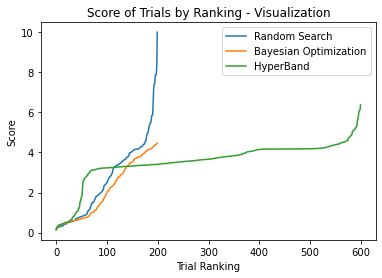

In [37]:
# Make a list of the scores for each trial
x = 200
scores_list = []
for i in range(x):
    scores_list.append(best_trials_rs[i].score)

fig, ax = plt.subplots()
ax.plot(scores_list, label='Random Search')

scores_list = []
for i in range(x):
    scores_list.append(best_trials_bo[i].score)
    
ax.plot(scores_list, label='Bayesian Optimization')

scores_list = []
x = 600
for i in range(x):
    scores_list.append(best_trials_hb[i].score)
    
ax.plot(scores_list, label='HyperBand')



ax.legend()
ax.set_title('Score of Trials by Ranking - Visualization')
ax.set_xlabel('Trial Ranking')
ax.set_ylabel('Score')
plt.show()

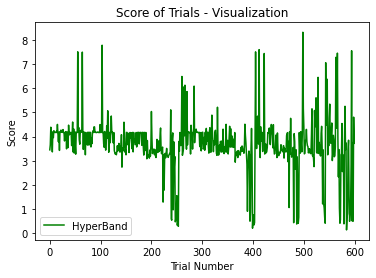

In [141]:
# Get the trials in order that they were generated, using the date/hour on the file.
arr = os.listdir('automl/metrica_bonita')
files = [val for val in arr
        if re.search(r'trial', val)]

files = [os.path.abspath('automl/metrica_bonita/' + val) for val in files]

files.sort(key=os.path.getctime)
files = [val.split('C:\\Users\\Poliana-N-Ferreira\\Documents\\CERN\\Project\\automl\\metrica_bonita\\trial_')[1] for val in files]

trials_in_order = [tuner_rs.oracle.get_trial(files[i]) for i in range(len(files))]

scores_list = []
x = 247
for i in range(x):
    scores_list.append(trials_in_order[i].score)
    
fig, ax = plt.subplots()
#ax.plot(scores_list, label='Random Search')


arr = os.listdir('automl1/metrica_bonita2')
files = [val for val in arr
        if re.search(r'trial', val)]

files = [os.path.abspath('automl1/metrica_bonita2/' + val) for val in files]

files.sort(key=os.path.getctime)
files = [val.split('C:\\Users\\Poliana-N-Ferreira\\Documents\\CERN\\Project\\automl1\\metrica_bonita2\\trial_')[1] for val in files]

trials_in_order = [tuner_bo.oracle.get_trial(files[i]) for i in range(len(files))]

scores_list = []
x = 247
for i in range(x):
    scores_list.append(trials_in_order[i].score)

#ax.plot(scores_list, label='Bayesian Optimization')



arr = os.listdir('automl2/metrica_bonita')
files = [val for val in arr
        if re.search(r'trial', val)]

files = [os.path.abspath('automl2/metrica_bonita/' + val) for val in files]

files.sort(key=os.path.getctime)
files = [val.split('C:\\Users\\Poliana-N-Ferreira\\Documents\\CERN\\Project\\automl2\\metrica_bonita\\trial_')[1] for val in files]

trials_in_order = [tuner_hb.oracle.get_trial(files[i]) for i in range(len(files))]

scores_list = []
x = 600
for i in range(x):
    scores_list.append(trials_in_order[i].score)


ax.plot(scores_list, label='HyperBand', color='green')

ax.legend()
ax.set_title('Score of Trials - Visualization')
ax.set_xlabel('Trial Number')
ax.set_ylabel('Score')
plt.show()

In [11]:
# Instantiate a model (0 is the best one, and the bigger the number, worst the model)
num = 0
vae_rs = best_vaes_rs[num]
tuner_rs.results_summary(num+1)

num = 0
vae_bo = best_vaes_bo[num]
tuner_bo.results_summary(num+1)

num = 0
vae_hb = best_vaes_hb[num]
tuner_hb.results_summary(num+1)
# Make a summary of the architecture of the model
#autoencoder.model().summary()

# Look at the hyperparameters in each of the num+1 best trials

Results summary
Results in automl\metrica_bonita
Showing 1 best trials
Objective(name='val_all', direction='min')
Trial summary
Hyperparameters:
latdim: 10
lr: 0.001
activ: softmax
wkl: 0.005
opt: 5
ki: RandomUniform
bi: GlorotNormal
layers: 3
intdim_0: 250
intdim_1: 200
batch_size: 90
epochs: 150
intdim_2: 750
intdim_3: 250
intdim_4: 200
intdim_5: 350
Score: 0.134211126580473
Results summary
Results in automl1\metrica_bonita2
Showing 1 best trials
Objective(name='val_all', direction='min')
Trial summary
Hyperparameters:
latdim: 10
lr: 0.01
activ: relu
wkl: 0.5
opt: 0
ki: HeNormal
bi: HeNormal
layers: 4
intdim_0: 100
intdim_1: 100
batch_size: 50
epochs: 90
intdim_2: 50
intdim_3: 100
intdim_4: 500
intdim_5: 1000
Score: 0.1800376437742897
Results summary
Results in automl2\metrica_bonita
Showing 1 best trials
Objective(name='val_all', direction='min')
Trial summary
Hyperparameters:
latdim: 10
lr: 0.0001
activ: softplus
wkl: 0.5
opt: 6
ki: LecunUniform
bi: HeUniform
layers: 3
intdim_0: 10

## Test the model

In [12]:
# Old models - trained by hand
def vaeLoss(G4_Event, VAE_Event):
            recoOrigSeqVox = K.sum(metrics.binary_crossentropy(G4_Event, VAE_Event))
            return K.mean(self.wReco*recoOrigSeqVox)

load_deco = tf.keras.models.load_model('./epoch_1000/epoch_1000_deco', custom_objects={"vaeLoss": vaeLoss})
load_enco = tf.keras.models.load_model('./epoch_1000/epoch_1000_enco', custom_objects={"vaeLoss": vaeLoss})
load_vae = tf.keras.models.load_model('./epoch_1000/epoch_1000_vae', custom_objects={"vaeLoss": vaeLoss})

### Similarity index for each layer on the detector from the test_data to the predicted values from the model.

In [38]:
# Reconstruct the test_data using the vae
noise = np.random.normal(0,1, size = (int(len(cell_energies)*0.1), 10))

enc_val = vae_rs.encode(test_data, noise).numpy()
pred_y = vae_rs.decode(enc_val).numpy()
reshaped_pred_y_rs = pred_y.reshape(len(pred_y),24,24,24)* maxE

enc_val = vae_bo.encode(test_data, noise).numpy()
pred_y = vae_bo.decode(enc_val).numpy()
reshaped_pred_y_bo = pred_y.reshape(len(pred_y),24,24,24)* maxE

enc_val = vae_hb.encode(test_data, noise).numpy()
pred_y = vae_hb.decode(enc_val).numpy()
reshaped_pred_y_hb = pred_y.reshape(len(pred_y),24,24,24)* maxE

pred_y = load_vae.predict((test_data, noise))
reshaped_pred_y_load = pred_y.reshape(len(pred_y),24,24,24)* maxE


reshaped_test_data = test_data.reshape(len(test_data),24,24,24)* maxE

SSIM for layer Random: [0.9967560568919038, 0.9870997347369487, 0.9636756870257058, 0.931672877880669, 0.8752063310691457, 0.8848549085877243, 0.9200319222373504, 0.9469743583653002, 0.9641293639227068, 0.9763736544193967, 0.9556604538795833, 0.9273860824042905, 0.8813475602842142, 0.8645177888057043, 0.8570326863342015, 0.833622598793409, 0.8298514668346789, 0.8245136311585686, 0.8211090987093785, 0.8178217522908718, 0.8181862622571893, 0.8140176461643582, 0.8107565438328653, 0.810205839885376]
SSIM for layer Bayesian: [0.9909228640773998, 0.9357705611839341, 0.8556806682088334, 0.7809349075420607, 0.7317994389970228, 0.8130868462405658, 0.8906831650623298, 0.9473372861600925, 0.9682798034163036, 0.9777589565732032, 0.9799887142752003, 0.993676076450663, 0.9905028116809876, 0.9857439731945424, 0.9882976612844577, 0.9952091412478313, 0.993971424798037, 0.9954830624395697, 0.9953918733434065, 0.9950376756487933, 0.9947854204643437, 0.9953523035715999, 0.9950099882296427, 0.9952498135471

(0.9, 1.0)

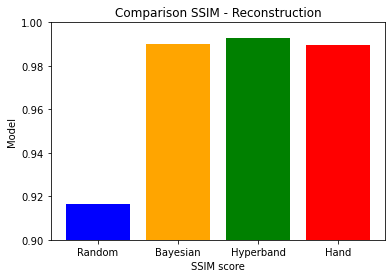

In [39]:
ssim_list_rs = []
ssim_list_bo = []
ssim_list_hb = []
ssim_list_load = []

# Calculate ssim for the mean of each layer from all the events
for i in range(0,24):
    ssim_value = ssim(np.mean(reshaped_pred_y_rs, axis=0)[i], np.mean(reshaped_test_data, axis=0)[i])
    ssim_list_rs.append(ssim_value)
    
    ssim_value = ssim(np.mean(reshaped_pred_y_bo, axis=0)[i], np.mean(reshaped_test_data, axis=0)[i])
    ssim_list_bo.append(ssim_value)
    
    ssim_value = ssim(np.mean(reshaped_pred_y_hb, axis=0)[i], np.mean(reshaped_test_data, axis=0)[i])
    ssim_list_hb.append(ssim_value)
    
    ssim_value = ssim(np.mean(reshaped_pred_y_load, axis=0)[i], np.mean(reshaped_test_data, axis=0)[i])
    ssim_list_load.append(ssim_value)
    
# Calculate ssim for the mean of all values from all the events
ssim_value_rs = ssim(np.mean(reshaped_pred_y_rs, axis=0), np.mean(reshaped_test_data, axis=0))
ssim_value_bo = ssim(np.mean(reshaped_pred_y_bo, axis=0), np.mean(reshaped_test_data, axis=0))
ssim_value_hb = ssim(np.mean(reshaped_pred_y_hb, axis=0), np.mean(reshaped_test_data, axis=0))
ssim_value_load = ssim(np.mean(reshaped_pred_y_load, axis=0), np.mean(reshaped_test_data, axis=0))

print("SSIM for layer Random:", ssim_list_rs)
print("SSIM for layer Bayesian:", ssim_list_bo)
print("SSIM for layer Hyperband:", ssim_list_hb)
print("SSIM for layer Hand:", ssim_list_load)
print("")
print("SSIM for all Random:", ssim_value_rs)
print("SSIM for all Bayesian:", ssim_value_bo)
print("SSIM for all Hyperband:", ssim_value_hb)
print("SSIM for all Hand:", ssim_value_load)

plt.bar(['Random', 'Bayesian', 'Hyperband', 'Hand'], [ssim_value_rs, ssim_value_bo, ssim_value_hb, ssim_value_load], 
        color=['blue', 'orange', 'green', 'red'])
plt.title('Comparison SSIM - Reconstruction')
plt.ylabel('Model')
plt.xlabel('SSIM score')
plt.ylim(0.9, 1.0)

### Comparison with plots of the Gaussian Distributions histograms (random and from the encoder) 

In [15]:
noise = np.random.normal(0,1, size = (cell_energies.shape[0],10))

enc_value_rs = vae_rs.encode(cell_energies, noise).numpy()
enc_value_bo = vae_bo.encode(cell_energies, noise).numpy()
enc_value_hb = vae_hb.encode(cell_energies, noise).numpy()
enc_value_load = load_enco.predict((cell_energies, noise))


z = np.random.normal(loc=0, scale=1, size= (len(cell_energies), 10))

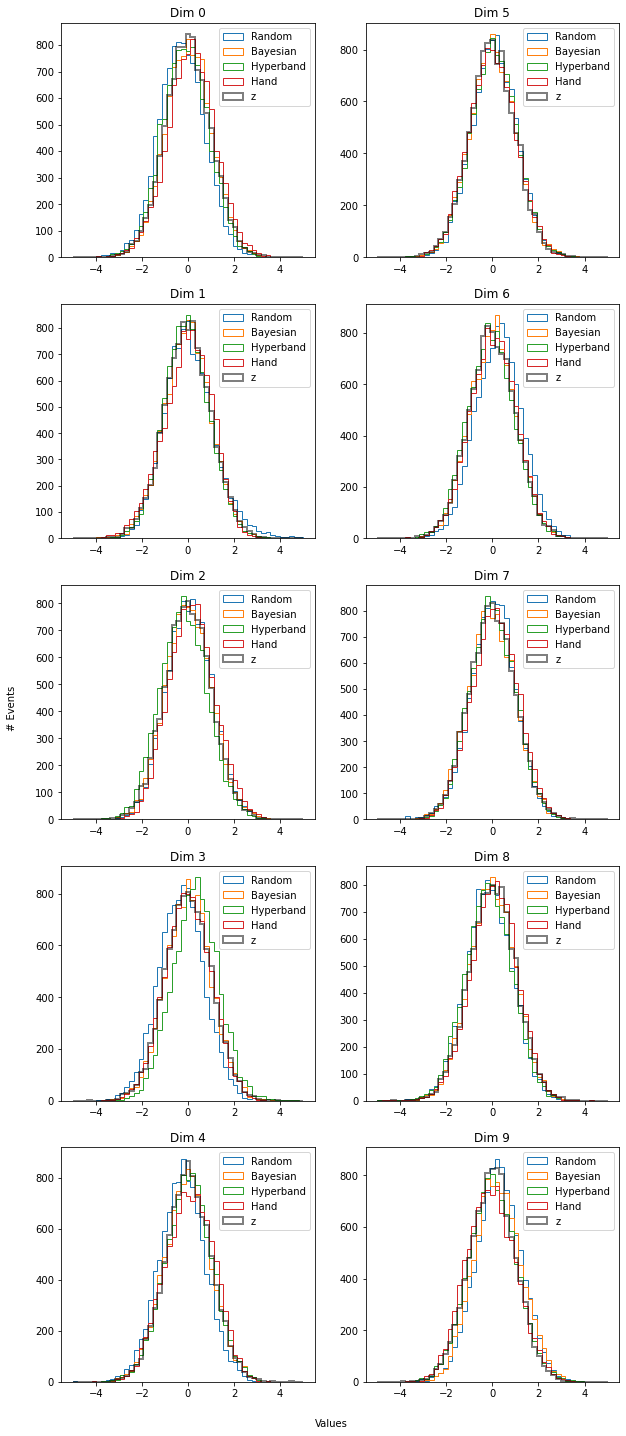

In [16]:
fig, axes = plt.subplots(5, 2, figsize=(10,25))
bins=np.linspace(-5, 5, 50)
for i in range(0,5):
    axes[i,0].hist(enc_value_rs[:,i], histtype='step', bins=bins, label='Random')
    axes[i,0].hist(enc_value_bo[:,i], histtype='step', bins=bins, label='Bayesian')
    axes[i,0].hist(enc_value_hb[:,i], histtype='step', bins=bins, label='Hyperband')
    axes[i,0].hist(enc_value_load[:,i], histtype='step', bins=bins, label='Hand')
    axes[i,0].hist(z[:, i], histtype='step', bins=bins, label='z', linewidth=2, color='black', alpha=0.5)
    axes[i,0].set_title("Dim %d" %i)
    axes[i,0].legend()
    #axes[i, 0].set_yscale('log')
    
    axes[i,1].hist(enc_value_rs[:,i+5], histtype='step', bins=bins, label='Random')
    axes[i,1].hist(enc_value_bo[:,i+5], histtype='step', bins=bins, label='Bayesian')
    axes[i,1].hist(enc_value_hb[:,i+5], histtype='step', bins=bins, label='Hyperband')
    axes[i,1].hist(enc_value_load[:,i+5], histtype='step', bins=bins, label='Hand')
    axes[i,1].hist(z[:, i+5], histtype='step', bins=bins, label='z', linewidth=2, color='black', alpha=0.5)
    axes[i,1].set_title('Dim %d' %(i+5))
    axes[i,1].legend()
    #axes[i, 1].set_yscale('log')
    

    
fig.text(0.5, 0.1, 'Values', ha='center')
fig.text(0.05, 0.5, '# Events ', va='center', rotation='vertical')

#plt.savefig('./hist_gaussian.png')
plt.show()
#print(mean_squared_error(np.histogram(z, bins=bins)[0], np.histogram(enc_value, bins=bins)[0])/100000)

### Plot for the total energy deposited in the calorimeter

In [18]:
# Generation from uncorrelated gaussians
z = np.random.normal(loc=0, scale=1, size= (len(cell_energies), 10) )

xRecoVal_rs = ( vae_rs.decode(z).numpy() ) 
xRecoVal_rs *= maxE

xRecoVal_bo = ( vae_bo.decode(z).numpy() ) 
xRecoVal_bo *= maxE

xRecoVal_hb = ( vae_hb.decode(z).numpy() ) 
xRecoVal_hb *= maxE

xRecoVal_load = load_deco.predict(z) 
xRecoVal_load *= maxE

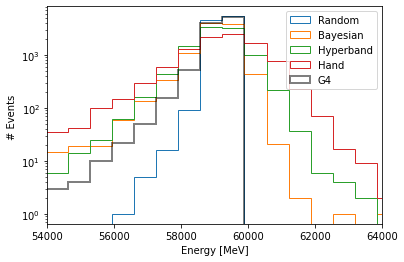

In [21]:
sumG4=np.array([ np.sum(i)* maxE for i in cell_energies ] )
sumVAE_rs=np.array([ np.sum(i) for i in xRecoVal_rs ] )
sumVAE_bo=np.array([ np.sum(i) for i in xRecoVal_bo ] )
sumVAE_hb=np.array([ np.sum(i) for i in xRecoVal_hb ] )
sumVAE_load=np.array([ np.sum(i) for i in xRecoVal_load ] )

bins2 = np.linspace( 0, max(np.max(sumG4), np.max(sumVAE_load) ), 100 )

plt.hist(sumVAE_rs,histtype='step',label='Random',bins=bins2)
plt.hist(sumVAE_bo,histtype='step',label='Bayesian',bins=bins2)
plt.hist(sumVAE_hb,histtype='step',label='Hyperband',bins=bins2)
plt.hist(sumVAE_load,histtype='step',label='Hand',bins=bins2)

plt.hist(sumG4,histtype='step',label='G4',bins=bins2, linewidth=2, color = 'black', alpha=0.5)


plt.legend()
plt.yscale('log')
plt.xlabel('Energy [MeV]')
plt.ylabel('# Events ')
plt.xlim(  54000, 64000 )

#plt.savefig('./total_energy.png')
plt.show()
#mean_squared_error(np.histogram(sumG4, bins=bins)[0], np.histogram(sumVAE, bins=bins2)[0])/1000000

### Plots for the sum of the energies per layer 

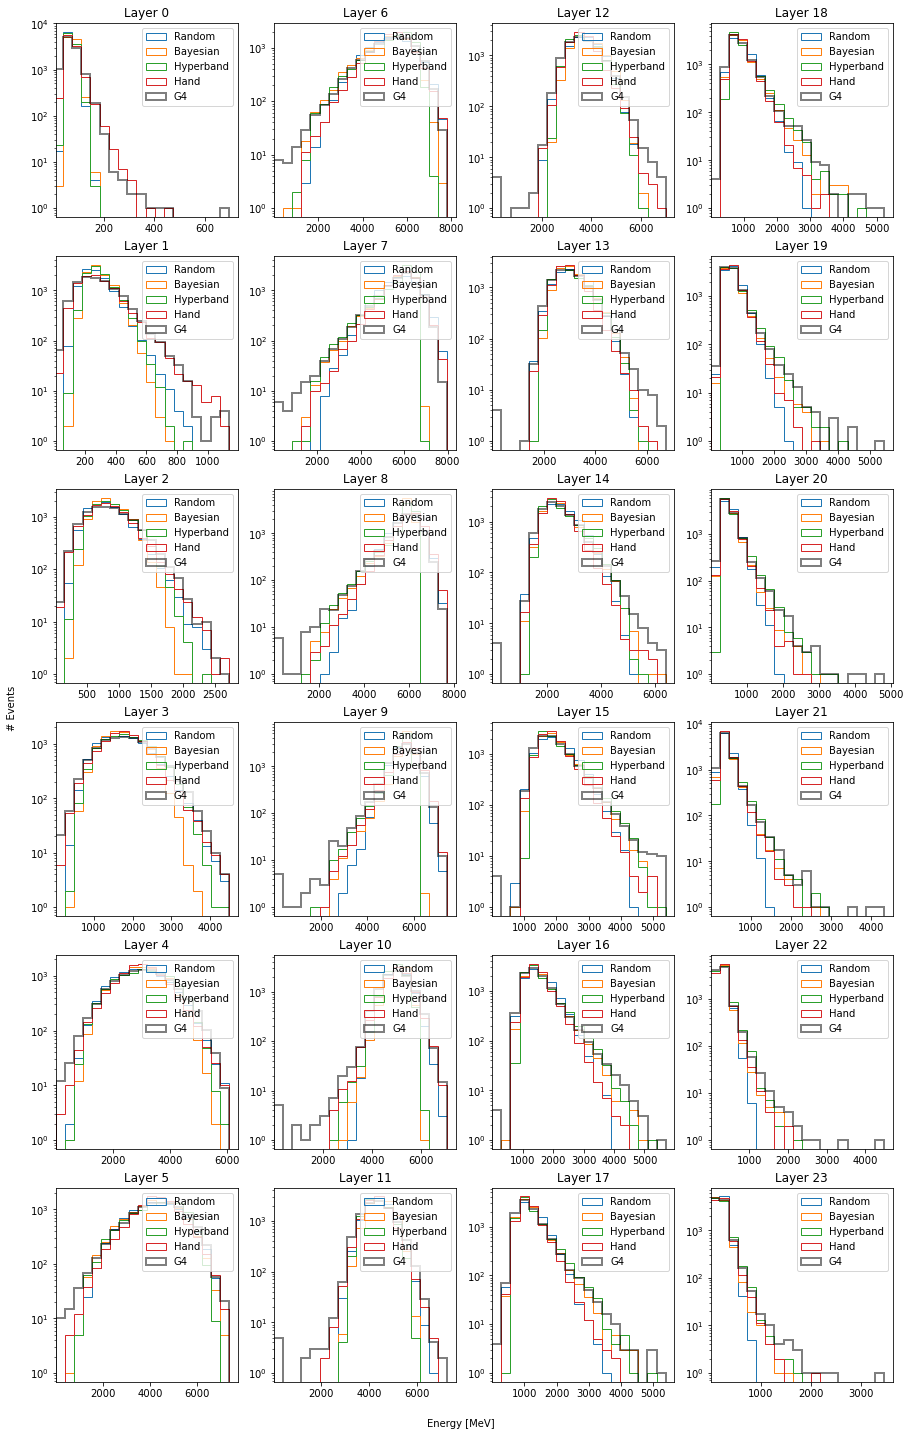

In [22]:
ReTranG4 = (cell_energies.reshape(len(cell_energies),24,24,24))*maxE
ReTranVAE_rs = xRecoVal_rs.reshape(len(xRecoVal_rs),24,24,24)
ReTranVAE_bo = xRecoVal_bo.reshape(len(xRecoVal_bo),24,24,24)
ReTranVAE_hb = xRecoVal_hb.reshape(len(xRecoVal_hb),24,24,24)
ReTranVAE_load = xRecoVal_load.reshape(len(xRecoVal_load),24,24,24)
fig, axes = plt.subplots(6, 4, figsize=(15,25))

for j in range(0,4):
    for i in range(0,6):
        eLayerVAE_rs = np.array([ np.sum(z) for z in ReTranVAE_rs[:,:,:,(i+(j*6))] ] )
        eLayerVAE_bo = np.array([ np.sum(z) for z in ReTranVAE_bo[:,:,:,(i+(j*6))] ] )
        eLayerVAE_hb = np.array([ np.sum(z) for z in ReTranVAE_hb[:,:,:,(i+(j*6))] ] )
        eLayerVAE_load = np.array([ np.sum(z) for z in ReTranVAE_load[:,:,:,(i+(j*6))] ] )
        eLayerG4 = np.array([ np.sum(z) for z in ReTranG4[:,:,:,(i+(j*6))] ] )

        bins=np.linspace( 0, np.max(eLayerG4), 20 )
        axes[i,j].hist(eLayerVAE_rs, histtype='step', label='Random',bins=bins)
        axes[i,j].hist(eLayerVAE_bo, histtype='step', label='Bayesian',bins=bins)
        axes[i,j].hist(eLayerVAE_hb, histtype='step', label='Hyperband',bins=bins)
        axes[i,j].hist(eLayerVAE_load, histtype='step', label='Hand',bins=bins)
        axes[i,j].hist(eLayerG4,histtype='step',label='G4',bins=bins, linewidth=2, color = 'black', alpha=0.5)
        axes[i,j].set_title("Layer %d" %(i+(j*6)))
        axes[i,j].legend()
        axes[i,j].set_yscale('log')
        axes[i,j].set_xlim(10)
        
fig.text(0.5, 0.1, 'Energy [MeV]', ha='center')
fig.text(0.08, 0.5, '# Events ', va='center', rotation='vertical')
#plt.savefig('energy_per_layer.png')
plt.show()